# Importing libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from captum.attr import IntegratedGradients
import altair as alt
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
seed = 0
torch.manual_seed(seed)

# Importing data

In [3]:
DF = pd.read_csv('../datasets/processed_data/combined_features/EIHOTEL.BO.csv.gz')

In [4]:
sentiments = ['agg_polarity', 'agg_compound', 'topic_polarity', 'topic_compound', 'ticker_polarity', 'ticker_compound']

In [5]:
DF.head()

,date,open,close,adj close,volume,high,low,volume_adi,volume_obv,volume_cmf,...,treasury_yeild_10_years_percent_change,usdx-index_percent_change,^nsei_percent_change,^bsesn_percent_change,^gspc_percent_change,hsi_percent_change,sha_percent_change,^sti_percent_change,yesterday_close,ln_target
0,2008-06-03,121.849998,120.699997,107.029884,10433,122.750000,119.000000,-35978.102872,60712,0.094102,...,-0.018383,0.004251,-0.026796,-0.021467,-0.010504,0.015385,-0.011495,0.0,119.900002,0.023492
1,2008-06-04,121.000000,119.000000,105.522438,9512,121.300003,118.000000,-39725.259719,51200,0.094102,...,-0.018383,0.004251,-0.005000,-0.006264,-0.005788,0.015385,-0.011495,0.0,120.699997,0.004959
2,2008-06-05,119.000000,117.500000,104.192314,133378,120.500000,113.199997,-15972.967314,-82178,0.094102,...,0.010775,0.002458,-0.027630,-0.028051,-0.000327,0.015385,-0.011495,0.0,119.000000,0.012526
3,2008-06-06,119.000000,118.349998,104.946053,12674,120.000000,115.250000,-12104.070194,-69504,0.094102,...,0.021574,-0.005176,0.019921,0.016431,0.019496,0.015385,-0.011495,0.0,117.500000,0.021053
4,2008-06-09,104.000000,115.050003,102.019806,28163,116.800003,104.000000,8358.111330,-97667,0.094102,...,0.021574,-0.005176,-0.010509,-0.012527,-0.030889,0.015385,-0.011495,0.0,118.349998,-0.013183


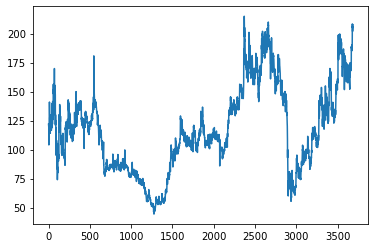

In [6]:
# Plot the stock
plt.plot(DF['open'].values)
plt.show()

In [7]:
# checking_number of features
len(list(DF.columns))

635

In [8]:
DF.shape

(3685, 635)

In [9]:
# Instead of predicting the stock price itself, 
# we will predict log value of "High"/"Yesterday Close" as we need stationary time-series 

In [10]:
def create_custom_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function creates the custom target price, which is computed as ln(high/yesterday_close)
    """    
    # make a copy of the dataframe so as not to change the original dataframe
    data_df = df.copy()
    
    # create yesterday_close feature as
    data_df['yesterday_close'] = data_df['close'].shift(1)
    
    # create custom target price to predict, computing  ln(high/yesterday_close)
    data_df['ln_target'] = np.log(data_df['high'] / data_df['yesterday_close'])
    
    # as yesterday close would not be available for first day, 
    # we would not have custom target price for that day, which needs to be excluded 
    return(data_df.iloc[1:, ])

In [11]:
DF = create_custom_target(DF)

In [12]:
DF.head(5)

,date,open,close,adj close,volume,high,low,volume_adi,volume_obv,volume_cmf,...,treasury_yeild_10_years_percent_change,usdx-index_percent_change,^nsei_percent_change,^bsesn_percent_change,^gspc_percent_change,hsi_percent_change,sha_percent_change,^sti_percent_change,yesterday_close,ln_target
1,2008-06-04,121.0,119.000000,105.522438,9512,121.300003,118.000000,-39725.259719,51200,0.094102,...,-0.018383,0.004251,-0.005000,-0.006264,-0.005788,0.015385,-0.011495,0.0,120.699997,0.004959
2,2008-06-05,119.0,117.500000,104.192314,133378,120.500000,113.199997,-15972.967314,-82178,0.094102,...,0.010775,0.002458,-0.027630,-0.028051,-0.000327,0.015385,-0.011495,0.0,119.000000,0.012526
3,2008-06-06,119.0,118.349998,104.946053,12674,120.000000,115.250000,-12104.070194,-69504,0.094102,...,0.021574,-0.005176,0.019921,0.016431,0.019496,0.015385,-0.011495,0.0,117.500000,0.021053
4,2008-06-09,104.0,115.050003,102.019806,28163,116.800003,104.000000,8358.111330,-97667,0.094102,...,0.021574,-0.005176,-0.010509,-0.012527,-0.030889,0.015385,-0.011495,0.0,118.349998,-0.013183
5,2008-06-10,114.0,117.349998,104.059303,36213,118.099998,113.900002,31637.887646,-61454,0.094102,...,0.021574,-0.005176,-0.027410,-0.032499,0.000794,-0.015228,-0.011495,0.0,115.050003,0.026165


# LSTM for all features

In [13]:
# First step we run LSTM model for all features (but only for teh last ~750 days), then we will use that model to 
# identify which features are the most important using Captum library.

In [14]:
df = DF.iloc[3286:,:]

In [15]:
input_data = df.drop(['ln_target', 'date'], axis=1).values
targets = df['ln_target'].values

In [16]:
targets.shape

(398,)

In [17]:
input_data.shape

(398, 633)

In [18]:
labels = df.drop(['ln_target', 'date'], axis=1).columns
labels

Index(['open', 'close', 'adj close', 'volume', 'high', 'low', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi',
       ...
       'cl=f_percent_change', 'treasury_yeild_10_years_percent_change',
       'usdx-index_percent_change', '^nsei_percent_change',
       '^bsesn_percent_change', '^gspc_percent_change', 'hsi_percent_change',
       'sha_percent_change', '^sti_percent_change', 'yesterday_close'],
      dtype='object', length=633)

In [19]:
len(targets)

398

In [20]:
# number of input features
input_data.shape[1]

633

In [21]:
# Preparing data the neural network
T = 65 # the number of days in one quarter to look at to make a prediction for the next day
D = input_data.shape[1] # number of features
N = len(input_data) - T # Number of samples with Time window length (e.g. if T=10 and you have 11 data points then you'd only have 1 sample and you will predict the 11th one)

In [22]:
input_data

array([[ 1.43199997e+02,  1.43800003e+02,  1.43800003e+02, ...,
        -1.11111111e-02,  1.22919909e-04,  1.41550003e+02],
       [ 1.46949997e+02,  1.39449997e+02,  1.39449997e+02, ...,
        -5.64971751e-03,  6.81509422e-03,  1.43800003e+02],
       [ 1.39399994e+02,  1.41750000e+02,  1.41750000e+02, ...,
         0.00000000e+00,  4.27004357e-03,  1.39449997e+02],
       ...,
       [ 2.03550003e+02,  2.04800003e+02,  2.04800003e+02, ...,
         0.00000000e+00, -4.14649077e-04,  2.04149994e+02],
       [ 2.05000000e+02,  2.06750000e+02,  2.06750000e+02, ...,
         0.00000000e+00, -2.78507454e-04,  2.04800003e+02],
       [ 2.07699997e+02,  2.08699997e+02,  2.08699997e+02, ...,
         0.00000000e+00, -3.25958932e-03,  2.06750000e+02]])

In [23]:
# split and normalize the inputs
Ntrain = len(input_data) * 4 // 5
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data[:Ntrain + T - 1] = scaler.transform(input_data[:Ntrain + T - 1])
input_data[Ntrain + T - 1:] = scaler.transform(input_data[Ntrain + T - 1:])

In [24]:
# We keep checking the length and shapes of input for PyTorch model

In [25]:
Ntrain

318

In [26]:
len(input_data)

398

In [27]:
Ntrain + T - 1

382

In [28]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))
for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T]
    Y_train[t] = targets[t+T]

In [29]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))
for u in range(N - Ntrain):
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = targets[t+T]

In [30]:
### LSTM model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        dropout = 0.5, # to avoid overfitting
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden and cell states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get LSTM output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step (-1)
    out = self.fc(out[:, -1, :])
    return out

In [31]:
# make the LSTM with 500 hidden features and 1 layers
model = RNN(input_data.shape[1], 600, 2, 1)
device = torch.device('cpu')
print(device)
model.to(device)

cpu


RNN(
  (rnn): LSTM(633, 600, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=600, out_features=1, bias=True)
)

In [32]:
# Loss and optimizer: Depends on the task different Loss function can be used 
# criterion = nn.BCEWithLogitsLoss() # if classification task
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [33]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [34]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [35]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [36]:
# Training
def full_gd(model,
           criterion,
           optimizer,
           X_train,
           y_train,
           X_test,
           y_test,
           epochs = 200):
    # stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        #zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        #Backward and optimize
        loss.backward()
        optimizer.step()
        
        #Save losses
        train_losses[it] = loss.item()
        
        #Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1)%5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, test Loss: {test_loss.item():.4f}')
            #checkpoint(model, f"LSTM/Epoch_EIHOTEL_633-{it+1}.pth") #  if you want to save each epoch model for further early stop model
    return train_losses, test_losses

In [37]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

Epoch 5/300, Train Loss: 4.1559, test Loss: 0.8718
Epoch 10/300, Train Loss: 1.5964, test Loss: 0.7833
Epoch 15/300, Train Loss: 0.6901, test Loss: 1.1835
Epoch 20/300, Train Loss: 1.3193, test Loss: 0.5676
Epoch 25/300, Train Loss: 1.2083, test Loss: 2.4430
Epoch 30/300, Train Loss: 0.4313, test Loss: 1.3655
Epoch 35/300, Train Loss: 1.3166, test Loss: 0.6095
Epoch 40/300, Train Loss: 1.1777, test Loss: 1.0717
Epoch 45/300, Train Loss: 0.6793, test Loss: 0.6184
Epoch 50/300, Train Loss: 1.3125, test Loss: 0.9128
Epoch 55/300, Train Loss: 1.2756, test Loss: 1.2906
Epoch 60/300, Train Loss: 1.3423, test Loss: 0.6444
Epoch 65/300, Train Loss: 0.6145, test Loss: 0.6193
Epoch 70/300, Train Loss: 0.9240, test Loss: 1.3397
Epoch 75/300, Train Loss: 1.1426, test Loss: 0.9895
Epoch 80/300, Train Loss: 1.0357, test Loss: 0.3767
Epoch 85/300, Train Loss: 1.2526, test Loss: 0.3055
Epoch 90/300, Train Loss: 1.2893, test Loss: 0.3699
Epoch 95/300, Train Loss: 1.0577, test Loss: 1.6021
Epoch 100/300

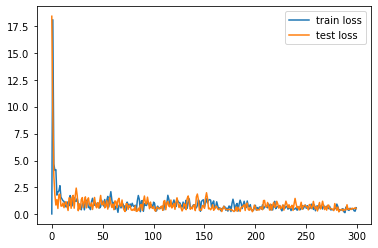

In [38]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [39]:
# Model results are not stable, but overall loss values goes down. 110 episodes are good enough to train the model (we tested more epochs).
# We can save weights for each episode and then retrieve the desired one (uncomment checkpoint line in def full_gd).

In [40]:
# retrieving 110th iteration
model = RNN(input_data.shape[1], 600, 2, 1)
model.load_state_dict(torch.load('LSTM/Epoch_EIHOTEL_633_all-110.pth'))
model.eval()

RNN(
  (rnn): LSTM(633, 600, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=600, out_features=1, bias=True)
)

In [41]:
X_on_device = X_test.to(device)

In [42]:
X_on_device.shape

torch.Size([15, 65, 633])

In [43]:
# One-step forecast 
test_target = np.exp(Y_test)
test_predictions = []
# index of first test input
i = 0
X_on_device = X_test.to(device)
while len(test_predictions) < len(test_target):
    input_ = X_on_device[i].reshape(-1, T, input_data.shape[1])
    p = model(input_)[0,0].item() 
    i += 1
    test_predictions.append(np.exp(p))

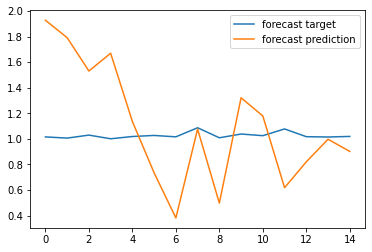

In [44]:
plt.plot(test_target, label = 'forecast target')
plt.plot(test_predictions, label = 'forecast prediction')
plt.legend()

In [45]:
# Low performance is most likely related to the noise or absence of signal?
# Lets do feature importance exercise with captum tool and run LSTM with top 50 selected features with sentiment and without

# Feature selection with Captum

As we have more than 600 features, first we apply Captum library which will help us which features are most important. For that we need to provide baseline (in this case we use zeros). Then the model will replace some features with baseline values and see the difference on outcome. There are several options in captum library, like global features, local features etc. We apply global ones to see which features are overall are the most critical for the model.

In [46]:
X_train.size()

torch.Size([318, 65, 633])

In [47]:
baseline = torch.zeros(Ntrain, T, input_data.shape[1])

In [48]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(X_train, baseline, method='gausslegendre', return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[[-5.9084e-04, -5.3741e-04, -5.2697e-04,  ...,  7.9753e-04,
           2.4487e-06, -6.4408e-04],
         [ 2.2772e-05,  3.7819e-05,  3.9749e-05,  ...,  5.2986e-05,
           1.2709e-04,  2.9571e-05],
         [ 2.1330e-05,  1.3794e-05,  1.1942e-05,  ...,  1.2511e-06,
           2.2580e-05,  1.8362e-05],
         ...,
         [-9.7817e-05, -7.2441e-05, -7.7905e-05,  ..., -6.7630e-04,
           3.8610e-05, -7.3702e-05],
         [-7.0183e-04, -3.3684e-04, -3.2322e-04,  ...,  2.3098e-03,
          -1.0412e-05, -6.4009e-04],
         [-1.4586e-08,  2.9006e-04,  3.0791e-04,  ..., -7.6655e-03,
          -3.5452e-04,  2.1865e-04]],

        [[ 4.1920e-04,  1.0461e-03,  1.2042e-03,  ...,  1.5684e-03,
          -4.0958e-03,  5.9612e-04],
         [-2.1013e-04, -1.7326e-04, -1.8029e-04,  ...,  8.5910e-06,
          -2.6212e-04, -2.1947e-04],
         [-8.3295e-05, -1.6275e-04, -1.5529e-04,  ..., -3.7265e-04,
           1.6197e-05, -1.2289e-04],
         ...,
        

In [49]:
attributions.size()

torch.Size([318, 65, 633])

In [50]:
at_0 = np.mean(np.array(attributions.cpu()),axis=0)

In [51]:
at_0.shape

(65, 633)

In [52]:
# We choose the last time step

In [53]:
a = at_0[T-1]

In [54]:
df_score = pd.DataFrame(zip(labels,a), columns = ['feature', 'score'])
df_score['score'] = np.abs(df_score['score'])
df_score.head(5)

,feature,score
0,open,0.000278
1,close,0.000311
2,adj close,0.000314
3,volume,0.000648
4,high,0.000296


In [55]:
# Then we create two dataframes: 1) Top 50 features without sentiment 2) Top 44 features + 6 sentiment features
df_no_sent = df_score[~df_score['feature'].isin(sentiments)]
df_no_sent = df_no_sent.sort_values('score').iloc[-50:,:]
selected_features_no_sentiments = list(df_no_sent['feature'])
selected_features_no_sentiments

['trend_kst_10',
 'trend_sma_fast_10',
 'momentum_tsi_50',
 'low',
 'tax_yrly',
 'momentum_roc_50',
 'volatility_bbh',
 'trend_psar_up_indicator_50',
 'momentum_pvo_50',
 'momentum_ppo_signal_50',
 'momentum_ppo_hist_50',
 'other_income_qtr',
 'others_cr',
 'momentum_ppo_50',
 'other_income_yrly',
 'trend_sma_fast_5',
 'trend_cci_20',
 'momentum_stoch_signal_50',
 'close',
 'volatility_bbli_10',
 'trend_visual_ichimoku_b_20',
 'others_dr_50',
 'adj close',
 'others_dlr_50',
 'momentum_pvo_signal_50',
 'trend_aroon_down_20',
 'volatility_bbh_5',
 'momentum_wr_50',
 'momentum_stoch_50',
 'momentum_pvo_hist_50',
 'trend_aroon_up_20',
 'momentum_kama_50',
 'others_cr_50',
 'momentum_ao_50',
 'trend_ichimoku_a_20',
 'yesterday_close',
 'momentum_stoch_rsi_20',
 'volatility_kcc_5',
 'trend_aroon_up_50',
 'trend_kst_20',
 'trend_ichimoku_b_20',
 'trend_visual_ichimoku_a_50',
 'trend_visual_ichimoku_b_50',
 'trend_aroon_down_50',
 'volatility_kcw_20',
 'volatility_bbm_10',
 'volume_sma_em_5',


In [56]:
selected_features_with_sentiments = selected_features_no_sentiments[:44] + sentiments

In [57]:
len(selected_features_with_sentiments)

50

# LSTM for selected features only without and with sentiments (_sf1/_sf2)

In [58]:
# With no sentiments
input_data_sf1 = DF[selected_features_no_sentiments].values
targets_sf1 = DF['ln_target'].values

In [59]:
# With sentiments
input_data_sf2 = DF[selected_features_with_sentiments].values
targets_sf2 = DF['ln_target'].values

In [62]:
# We can use same features for other modells
#DF[selected_features_no_sentiments].to_csv('../datasets/exported/LSTM_EIHOTEL_no_sentiemnts.csv')
#DF[selected_features_with_sentiments].to_csv('../datasets/exported/LSTM_EIHOTEL_with_sentiemnts.csv')

In [63]:
# Preparing data for the neural network
T_sf1 = 10 # the number of days in  (a week, month, one quarter) to look at to make a prediction for the next day (Time window - look back)
D_sf1 = input_data_sf1.shape[1] # number of features
N_sf1 = len(input_data_sf1) - T_sf1 # Number of samples with Time window length

In [64]:
# Preparing data for the neural network
T_sf2 = 10 # the number of days in (a week, month, one quarter) to look at to make a prediction for the next day (Time window - look back)
D_sf2 = input_data_sf2.shape[1] # number of features
N_sf2 = len(input_data_sf2) - T_sf2 # Number of samples with Time window length 

In [65]:
D_sf1

50

In [66]:
N_sf1

3674

In [67]:
# split and normalize the inputs for selected features for model with no sentiments
Ntrain_sf1 = len(input_data_sf1) * 4 // 5
scaler_sf1 = StandardScaler()
scaler_sf1.fit(input_data_sf1[:Ntrain_sf1 + T_sf1 - 1])
input_data_sf1[:Ntrain_sf1 + T_sf1 - 1] = scaler_sf1.transform(input_data_sf1[:Ntrain_sf1 + T_sf1 - 1])
input_data_sf1[Ntrain_sf1 + T_sf1 - 1:] = scaler_sf1.transform(input_data_sf1[Ntrain_sf1 + T_sf1 - 1:])

In [68]:
# split and normalize the inputs for selected features for model with sentiments
Ntrain_sf2 = len(input_data_sf2) * 4 // 5
scaler_sf2 = StandardScaler()
scaler_sf2.fit(input_data_sf2[:Ntrain_sf2 + T_sf2 - 1])
input_data_sf2[:Ntrain_sf2 + T_sf2 - 1] = scaler_sf2.transform(input_data_sf2[:Ntrain_sf2 + T_sf2 - 1])
input_data_sf2[Ntrain_sf2 + T_sf2 - 1:] = scaler_sf2.transform(input_data_sf2[Ntrain_sf2 + T_sf2 - 1:])

In [69]:
Ntrain_sf1 + T_sf1 - 1

2956

In [70]:
# Setup X_train_sf and Y_train_sf for model with no sentiments
X_train_sf1 = np.zeros((Ntrain_sf1, T_sf1, D_sf1))
Y_train_sf1 = np.zeros((Ntrain_sf1, 1))
for t_sf1 in range(Ntrain_sf1):
    X_train_sf1[t_sf1, :, :] = input_data_sf1[t_sf1:t_sf1+T_sf1]
    Y_train_sf1[t_sf1] = targets_sf1[t_sf1+T_sf1]

In [71]:
# Setup X_train_sf and Y_train_sf for model with sentiments
X_train_sf2 = np.zeros((Ntrain_sf2, T_sf2, D_sf2))
Y_train_sf2 = np.zeros((Ntrain_sf2, 1))
for t_sf2 in range(Ntrain_sf2):
    X_train_sf2[t_sf2, :, :] = input_data_sf2[t_sf2:t_sf2+T_sf2]
    Y_train_sf2[t_sf2] = targets_sf2[t_sf2+T_sf2]


In [72]:
# Setup X_test_sf and Y_test_sf for model with no sentiments
X_test_sf1 = np.zeros((N_sf1 - Ntrain_sf1, T_sf1, D_sf1))
Y_test_sf1 = np.zeros((N_sf1 - Ntrain_sf1, 1))
for z_sf1 in range(N_sf1 - Ntrain_sf1):
    # z_sf1 counts from 0...(N_sf1 - Ntrain_sf1)
    # t_sf1 counts from Ntrain_sf1...N_sf1
    t_sf1 = z_sf1 + Ntrain_sf1
    X_test_sf1[z_sf1, :, :] = input_data_sf1[t_sf1:t_sf1+T_sf1]
    Y_test_sf1[z_sf1] = targets_sf1[t_sf1+T_sf1]

In [73]:
# Setup X_test_sf and Y_test_sf for model with sentiments
X_test_sf2 = np.zeros((N_sf2 - Ntrain_sf2, T_sf2, D_sf2))
Y_test_sf2 = np.zeros((N_sf2 - Ntrain_sf2, 1))
for z_sf2 in range(N_sf2 - Ntrain_sf2):
    # z_sf2 counts from 0...(N_sf2 - Ntrain_sf2)
    # t_sf2 counts from Ntrain_sf2...N_sf2
    t_sf2 = z_sf2 + Ntrain_sf2
    X_test_sf2[z_sf2, :, :] = input_data_sf2[t_sf2:t_sf2+T_sf2]
    Y_test_sf2[z_sf2] = targets_sf2[t_sf2+T_sf2]

In [74]:
### LSTM model for model with no sentiments (to be able to change parameters if required)
class RNN_sf1(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN_sf1, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden and cell states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get LSTM unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step (-1)
    out = self.fc(out[:, -1, :])
    return out

In [75]:
model_sf1 = RNN_sf1(input_data_sf1.shape[1], 45, 1, 1) # the number of hidden features 45 (less than 50), 1 hidden layer
device = torch.device('cpu')
model_sf1.to(device)

RNN_sf1(
  (rnn): LSTM(50, 45, batch_first=True)
  (fc): Linear(in_features=45, out_features=1, bias=True)
)

In [76]:
### LSTM model for model with sentiments (to be able to change parameters if required)
class RNN_sf2(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN_sf2, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden and cell states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get LSTM unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step (-1)
    out = self.fc(out[:, -1, :])
    return out

In [77]:
model_sf2 = RNN_sf2(input_data_sf2.shape[1], 45, 1, 1)
device = torch.device('cpu')
model_sf2.to(device)

RNN_sf2(
  (rnn): LSTM(50, 45, batch_first=True)
  (fc): Linear(in_features=45, out_features=1, bias=True)
)

In [78]:
# Loss and optimizer for model with no sentiments (to be able to change parameters if required)
# criterion = nn.BCEWithLogitsLoss() # if classification task
criterion_sf1 = nn.L1Loss()
optimizer_sf1 = torch.optim.Adam(model_sf1.parameters(), lr=0.1)

In [79]:
# Loss and optimizer for model with sentiments (to be able to change parameters if required)
# criterion = nn.BCEWithLogitsLoss() # if classification task
criterion_sf2 = nn.L1Loss()
optimizer_sf2 = torch.optim.Adam(model_sf2.parameters(), lr=0.1)

In [80]:
# Make inputs and targets to Torch format (tenzors)
X_train_sf1 = torch.from_numpy(X_train_sf1.astype(np.float32))
y_train_sf1 = torch.from_numpy(Y_train_sf1.astype(np.float32))
X_test_sf1 = torch.from_numpy(X_test_sf1.astype(np.float32))
y_test_sf1 = torch.from_numpy(Y_test_sf1.astype(np.float32))

In [81]:
# Make inputs and targets to Torch format (tenzors)
X_train_sf2 = torch.from_numpy(X_train_sf2.astype(np.float32))
y_train_sf2 = torch.from_numpy(Y_train_sf2.astype(np.float32))
X_test_sf2 = torch.from_numpy(X_test_sf2.astype(np.float32))
y_test_sf2 = torch.from_numpy(Y_test_sf2.astype(np.float32))

In [82]:
# move data to CPU (in case of Nvidia GPU card --> cuda)
X_train_sf1, y_train_sf1 = X_train_sf1.to(device), y_train_sf1.to(device)
X_test_sf1, y_test_sf1 = X_test_sf1.to(device), y_test_sf1.to(device)

In [83]:
# move data to CPU (in case of Nvidia GPU card --> cuda)
X_train_sf2, y_train_sf2 = X_train_sf2.to(device), y_train_sf2.to(device)
X_test_sf2, y_test_sf2 = X_test_sf2.to(device), y_test_sf2.to(device)

In [84]:
# Training
def full_gd_sf(model,
           criterion,
           optimizer,
           X_train,
           y_train,
           X_test,
           y_test,
           epochs = 200):
    # Losses to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        #zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        #Backward and optimize
        loss.backward()
        optimizer.step()
        
        #Save losses
        train_losses[it] = loss.item()
        
        #Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1)%5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, test Loss: {test_loss.item():.4f}')
            #checkpoint(model, f"LSTM/Epoch_EIHOTEL_50-{it+1}.pth") # uncomment if you want to update the weights
    return train_losses, test_losses

In [85]:
train_losses_sf1, test_losses_sf1 = full_gd_sf(model_sf1,
                                    criterion_sf1,
                                    optimizer_sf1,
                                    X_train_sf1,
                                    y_train_sf1,
                                    X_test_sf1,
                                    y_test_sf1,
                                    epochs=150)

Epoch 5/150, Train Loss: 0.3420, test Loss: 0.5402
Epoch 10/150, Train Loss: 0.2523, test Loss: 0.3799
Epoch 15/150, Train Loss: 0.2991, test Loss: 0.2927
Epoch 20/150, Train Loss: 0.2368, test Loss: 0.1745
Epoch 25/150, Train Loss: 0.1612, test Loss: 0.2341
Epoch 30/150, Train Loss: 0.0982, test Loss: 0.1419
Epoch 35/150, Train Loss: 0.1701, test Loss: 0.0726
Epoch 40/150, Train Loss: 0.0694, test Loss: 0.1247
Epoch 45/150, Train Loss: 0.0707, test Loss: 0.1121
Epoch 50/150, Train Loss: 0.1375, test Loss: 0.0869
Epoch 55/150, Train Loss: 0.0876, test Loss: 0.1487
Epoch 60/150, Train Loss: 0.0621, test Loss: 0.1046
Epoch 65/150, Train Loss: 0.1086, test Loss: 0.0605
Epoch 70/150, Train Loss: 0.0805, test Loss: 0.1077
Epoch 75/150, Train Loss: 0.0524, test Loss: 0.0724
Epoch 80/150, Train Loss: 0.0665, test Loss: 0.0589
Epoch 85/150, Train Loss: 0.0465, test Loss: 0.0696
Epoch 90/150, Train Loss: 0.0373, test Loss: 0.0617
Epoch 95/150, Train Loss: 0.0699, test Loss: 0.0493
Epoch 100/150

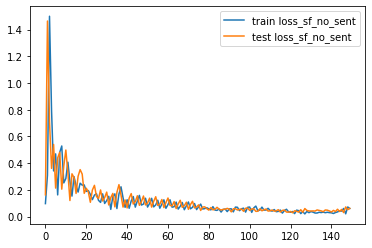

In [86]:
# Plot the train loss and test loss per iteration for selected features (no sentiments)
plt.plot(train_losses_sf1, label='train loss_sf_no_sent')
plt.plot(test_losses_sf1, label='test loss_sf_no_sent')
plt.legend()
plt.show()

In [87]:
train_losses_sf2, test_losses_sf2 = full_gd_sf(model_sf2,
                                    criterion_sf2,
                                    optimizer_sf2,
                                    X_train_sf2,
                                    y_train_sf2,
                                    X_test_sf2,
                                    y_test_sf2,
                                    epochs=150)

Epoch 5/150, Train Loss: 0.2295, test Loss: 0.6843
Epoch 10/150, Train Loss: 0.4033, test Loss: 0.6416
Epoch 15/150, Train Loss: 0.2762, test Loss: 0.3348
Epoch 20/150, Train Loss: 0.1974, test Loss: 0.1326
Epoch 25/150, Train Loss: 0.1391, test Loss: 0.1119
Epoch 30/150, Train Loss: 0.1293, test Loss: 0.0655
Epoch 35/150, Train Loss: 0.0864, test Loss: 0.0904
Epoch 40/150, Train Loss: 0.0649, test Loss: 0.0591
Epoch 45/150, Train Loss: 0.1221, test Loss: 0.0815
Epoch 50/150, Train Loss: 0.0859, test Loss: 0.0995
Epoch 55/150, Train Loss: 0.0465, test Loss: 0.0597
Epoch 60/150, Train Loss: 0.0991, test Loss: 0.0490
Epoch 65/150, Train Loss: 0.0697, test Loss: 0.0757
Epoch 70/150, Train Loss: 0.0840, test Loss: 0.0360
Epoch 75/150, Train Loss: 0.1023, test Loss: 0.0464
Epoch 80/150, Train Loss: 0.0842, test Loss: 0.0664
Epoch 85/150, Train Loss: 0.0409, test Loss: 0.0435
Epoch 90/150, Train Loss: 0.0639, test Loss: 0.0323
Epoch 95/150, Train Loss: 0.0651, test Loss: 0.0669
Epoch 100/150

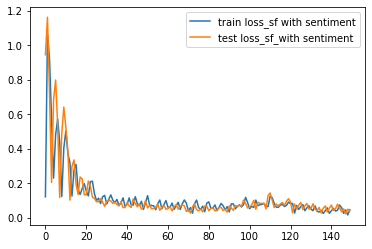

In [88]:
# Plot the train loss and test loss per iteration for selected features (with sentiments)
plt.plot(train_losses_sf2, label='train loss_sf with sentiment')
plt.plot(test_losses_sf2, label='test loss_sf_with sentiment')
plt.legend()
plt.show()

In [89]:
# retrieving 150th iteration
model_sf1 = RNN_sf1(input_data_sf1.shape[1], 45, 1, 1)
model_sf1.load_state_dict(torch.load('LSTM/Epoch_EIHOTEL_no_sent_50-150.pth'))
model_sf1.eval()

RNN_sf1(
  (rnn): LSTM(50, 45, batch_first=True)
  (fc): Linear(in_features=45, out_features=1, bias=True)
)

In [90]:
# retrieving 150th iteration
model_sf2 = RNN_sf1(input_data_sf1.shape[1], 45, 1, 1)
model_sf2.load_state_dict(torch.load('LSTM/Epoch_EIHOTEL_w_sent_50-150.pth'))
model_sf2.eval()

RNN_sf1(
  (rnn): LSTM(50, 45, batch_first=True)
  (fc): Linear(in_features=45, out_features=1, bias=True)
)

In [91]:
X_on_device_sf1 = X_test_sf1.to(device)
X_on_device_sf2 = X_test_sf2.to(device)

In [92]:
X_on_device_sf1.shape

torch.Size([727, 10, 50])

In [93]:
# One-day forecast 
test_target_sf1 = Y_test_sf1
test_predictions_sf1 = []
# index of first validation input
i_sf1 = 0

X_on_device_sf1 = X_test_sf1.to(device)
while len(test_predictions_sf1) < len(test_target_sf1):
    input__sf1 = X_on_device_sf1[i_sf1].reshape(-1, T_sf1, input_data_sf1.shape[1])
    p_sf1 = model_sf1(input__sf1)[0,0].item() 
    i_sf1 += 1
    test_predictions_sf1.append(p_sf1)

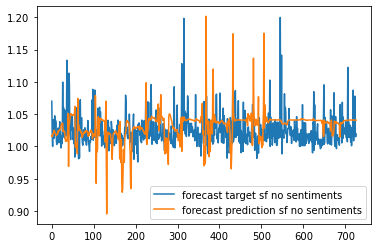

In [94]:
plt.plot(np.exp(test_target_sf1), label = 'forecast target sf no sentiments')
plt.plot(np.exp(test_predictions_sf1), label = 'forecast prediction sf no sentiments')
plt.legend()

In [95]:
# We see that time window impacts our predictions, the predicted values are lower at the beginning than the test one, second half is higher. 

In [96]:
# One-step forecast 
test_target_sf2 = Y_test_sf2
test_predictions_sf2 = []
# index of first validation input
i_sf2 = 0

X_on_device_sf2 = X_test_sf2.to(device)
while len(test_predictions_sf2) < len(test_target_sf2):
    input__sf2 = X_on_device_sf2[i_sf2].reshape(-1, T_sf2, input_data_sf2.shape[1])
    p_sf2 = model_sf2(input__sf2)[0,0].item() 
    i_sf2 += 1
    test_predictions_sf2.append(p_sf2)

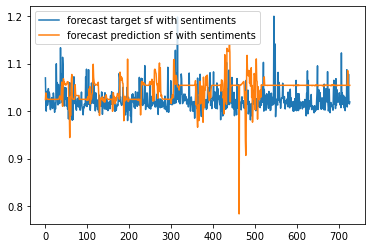

In [97]:
plt.plot(np.exp(test_target_sf2), label = 'forecast target sf with sentiments')
plt.plot(np.exp(test_predictions_sf2), label = 'forecast prediction sf with sentiments')
plt.legend()

In [98]:
mean_absolute_percentage_error(np.exp(test_target_sf1), np.exp(test_predictions_sf1))

0.02463781837501426

In [99]:
mean_absolute_percentage_error(np.exp(test_target_sf2), np.exp(test_predictions_sf2))

0.031969757781960484

# Visualization of results

For visulaisation purpose, we use Altair library, which requires 'long-shape' dataframe. First we merge predicted values with original dataframe, then we transform it to Altair format.

In [100]:
pred_date = DF.iloc[-len(y_test_sf1):,0]

In [101]:
# converting back to target predictions
results_array = np.column_stack((pred_date,np.exp(test_predictions_sf1),np.exp(test_predictions_sf2)))

In [102]:
# Creating dataframe with results
df_result = pd.DataFrame({"date":results_array .T[0],
                   "LSTM (no sentiments)":results_array .T[1],
                   "LSTM (with sentiments)":results_array .T[2]})

In [103]:
columns = ['date','high','yesterday_close', 'ln_target']

In [104]:
# Merging results with the actual data
result = pd.merge(DF[columns], df_result, how="left", on=["date", "date"])

In [105]:
# Recalculating predicted High price from return
result['Predicted high LSTM (no sentiments)'] = result['yesterday_close']*result['LSTM (no sentiments)']
result['Predicted high LSTM (with sentiments)'] = result['yesterday_close']*result['LSTM (with sentiments)']
result['Actual High/Close_yesterday'] = np.exp(result['ln_target'])
result = result.drop('ln_target', axis=1)
result.rename(columns = {'high':'Actual High'}, inplace = True)

In [106]:
# Let's focus only on test interval
result = result.iloc[-len(y_test_sf1):,:]

In [107]:
result.head()

,date,Actual High,yesterday_close,LSTM (no sentiments),LSTM (with sentiments),Predicted high LSTM (no sentiments),Predicted high LSTM (with sentiments),Actual High/Close_yesterday
2957,2020-06-23,74.900002,70.000000,1.016788,1.024406,71.175152,71.708446,1.070000
2958,2020-06-24,74.949997,73.599998,1.015016,1.038335,74.705208,76.42146,1.018342
2959,2020-06-25,68.900002,68.900002,1.017608,1.029606,70.113211,70.939858,1.000000
2960,2020-06-26,69.000000,66.800003,1.019854,1.026725,68.12624,68.58522,1.032934
2961,2020-06-29,68.750000,66.000000,1.020953,1.025211,67.382884,67.663916,1.041667


In [108]:
result.columns

Index(['date', 'Actual High', 'yesterday_close', 'LSTM (no sentiments)',
       'LSTM (with sentiments)', 'Predicted high LSTM (no sentiments)',
       'Predicted high LSTM (with sentiments)', 'Actual High/Close_yesterday'],
      dtype='object')

In [109]:
result[['date', 'Actual High','Predicted high LSTM (no sentiments)',
        'Predicted high LSTM (with sentiments)']].to_csv('../datasets/processed_data/model_predictions/LSTM/EIHOTEL_LSTM_predictions.csv', index = False)

In [110]:
# MAPE calculation for predicted "High" price
a = mean_absolute_percentage_error(result['Predicted high LSTM (no sentiments)'], result['Actual High'])
b = mean_absolute_percentage_error(result['Predicted high LSTM (with sentiments)'],result['Actual High'])
print(a,b)

0.024514787211180066 0.03123882742266976


In [111]:
# For Altair visualization we melt pandas dataframes into long shape format and then concat them
melted_df1 = pd.melt(result, id_vars =['date','yesterday_close'],
                     value_vars =['Actual High','Predicted high LSTM (no sentiments)','Predicted high LSTM (with sentiments)'],
                    var_name ='High method', value_name ='High prediction price')
melted_df2 = pd.melt(result, id_vars =['date','yesterday_close'], value_vars =['Actual High/Close_yesterday','LSTM (no sentiments)','LSTM (with sentiments)'],
                    var_name ='High/Close_yesterday method', value_name ='High/Close_yesterday')
melted_df = pd.concat([melted_df1,melted_df2[['High/Close_yesterday method','High/Close_yesterday']]], axis = 1)

In [112]:
melted_df.head(5)

,date,yesterday_close,High method,High prediction price,High/Close_yesterday method,High/Close_yesterday
0,2020-06-23,70.000000,Actual High,74.900002,Actual High/Close_yesterday,1.07
1,2020-06-24,73.599998,Actual High,74.949997,Actual High/Close_yesterday,1.018342
2,2020-06-25,68.900002,Actual High,68.900002,Actual High/Close_yesterday,1.0
3,2020-06-26,66.800003,Actual High,69.0,Actual High/Close_yesterday,1.032934
4,2020-06-29,66.000000,Actual High,68.75,Actual High/Close_yesterday,1.041667


In [113]:
# use the 538 theme
alt.themes.enable('fivethirtyeight')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [114]:
high_price = alt.Chart(melted_df, title="EIHOTEL LSTM 'high' stock price prediction results").mark_line().encode(
    x=alt.X('date:T', title="Year"),
    y = alt.Y('High prediction price:Q', title="Price"),
    color = alt.Color('High method:N',legend=alt.Legend(orient='left',direction = 'vertical',labelLimit = 400))
    ).properties(height = 250, width = 800
    ).configure_legend(
    offset=-330,
    symbolDirection='vertical',
        titleFontSize=16,
        labelFontSize=14
    )

high_price.interactive()

alt.Chart(...)

In [115]:
high_close_yesterday_ratio = alt.Chart(melted_df, title="EIHOTEL LSTM 'High / Close_yesterday' stock price prediction results").mark_line().encode(
    x=alt.X('date:T', title="Year"),
    y = alt.Y('High/Close_yesterday:Q', title="High / Close_yesterday"),
    color = alt.Color('High/Close_yesterday method:N',
                      legend=alt.Legend(orient='right',direction = 'vertical',labelLimit = 400))
    ).properties(height = 250, width = 800
    ).configure_legend(
    offset=-220,
    symbolDirection='vertical',
        titleFontSize=16,
        labelFontSize=14
    )

high_close_yesterday_ratio.interactive()

alt.Chart(...)

In [116]:
# Both models show poor performance for High/Close_yesterday prediction. 
# Overall model with sentiments fits a bit better.